# **1. Preliminary Preparations**

[Data Expo 2009: Airline On Time Data](https://www.kaggle.com/datasets/wenxingdi/data-expo-2009-airline-on-time-data/data?select=2007.csv)

## 1.1 Necessary Packages

In [43]:
import pandas as pd
from impala.dbapi import connect
import matplotlib.pyplot as plt

## 1.2 Connect to HIVE

In [44]:
conn =connect(
  host="192.168.153.129",
  port=10000,
  user="maria_dev",
  database="default",
  auth_mechanism="PLAIN"
)
cursor = conn.cursor()
cursor.execute("SHOW TABLES")
print(cursor.fetchall())

[('gdp_per_capita',), ('inflation_rate',), ('year_2007',)]


## 1.3 Table Description

In [45]:
cursor.execute("DESCRIBE year_2007")
print(cursor.fetchall())

[('year', 'int', ''), ('month', 'int', ''), ('dayofmonth', 'int', ''), ('dayofweek', 'int', ''), ('deptime', 'int', ''), ('crsdeptime', 'int', ''), ('arrtime', 'int', ''), ('crsarrtime', 'int', ''), ('uniquecarrier', 'string', ''), ('flightnum', 'int', ''), ('tailnum', 'string', ''), ('actualelapsedtime', 'int', ''), ('crselapsedtime', 'int', ''), ('airtime', 'int', ''), ('arrdelay', 'int', ''), ('depdelay', 'int', ''), ('origin', 'string', ''), ('dest', 'string', ''), ('distance', 'int', ''), ('taxiin', 'int', ''), ('taxiout', 'int', ''), ('cancelled', 'int', ''), ('cancellationcode', 'string', ''), ('diverted', 'int', ''), ('carrierdelay', 'int', ''), ('weatherdelay', 'int', ''), ('nasdelay', 'int', ''), ('securitydelay', 'int', ''), ('lateaircraftdelay', 'int', '')]


<center><strong>Basic Flight Info</strong></center>   

**year** : Year of the flight  
**month** : Month of the flight  
**dayofmonth** : Day of the month the flight occurred  
**dayofweek** : Day of the week (1 = Monday, 7 = Sunday)  
**uniquecarrier** : Airline carrier code (e.g., AA, UA, WN)  
**flightnum** : Flight number  
**tailnum** : Aircraft tail number  

---
<center><strong>Flight Schedule and Timing</strong></center>  

**deptime** : Actual departure time (in HHMM format)  
**crsdeptime** : Scheduled departure time (in HHMM format)  
**arrtime** : Actual arrival time (in HHMM format)  
**crsarrtime** : Scheduled arrival time (in HHMM format) 

---
<center><strong>Elapsed Time</strong></center>  

**actualelapsedtime** : Actual total time of flight (in minutes)  
**crselapsedtime** : Scheduled elapsed time of flight (in minutes)  
**airtime** : Time spent in the air (in minutes)  
**taxiin** : Taxi-in time after landing (in minutes)  
**taxiout** : Taxi-out time before takeoff (in minutes)  

---
<center><strong>Delay Information</strong></center>  

**arrdelay** : Arrival delay (in minutes)  
**depdelay** : Departure delay (in minutes)  

---
<center><strong>Cancellation and Diversion</strong></center>  

**cancelled** : Flight cancellation indicator (1 = cancelled, 0 = not cancelled)  
**cancellationcode** : Reason for cancellation(A = Carrier,B = Weather,C = NAS (Air Traffic Control),D = Security)  
**diverted** : Diversion indicator (1 = diverted, 0 = not diverted)  

---
<center><strong>Detailed Delay Causes</strong></center>  

**carrierdelay** : Delay due to airline issues (in minutes)  
**weatherdelay** : Delay due to weather (in minutes)  
**nasdelay** : Delay caused by the National Airspace System (in minutes)  
**securitydelay** : Delay caused by security issues (in minutes)  
**lateaircraftdelay** ： Delay caused by a late incoming aircraft (in minutes) 

---
<center><strong>Route Information</strong></center>  

**origin** : Origin airport IATA code  
**dest** : Destination airport IATA code  
**distance** : Distance between origin and destination (in miles)  

---

# **2. Delay Patterns**

*In this section, I analyze flight delay patterns from three temporal perspectives: time of day, day of the week, and month/season. I examine both average arrival delays and on-time arrival rates to identify when flights are more likely to be punctual. The findings highlight temporal trends in flight performance and offer practical recommendations for travelers to plan their trips more effectively.*


## 2.1 Delay Variation by Time of Day

**Time zones**  
Late Night: 00:00 - 4:59  
Morning: 5:00 - 11:59  
Afternoon: 12:00 - 17:59  
Evening: 18:00 - 23:59  

[*Time-of-day categorization is proposed according to the supplemental/dayPeriods.xml definitions in the CLDR (Unicode Common Locale Data Repository) database.*](https://cldr.unicode.org/development/development-process/design-proposals/day-period-design)

### 2.1.1 Average Departure Delay by Time Period

In [46]:
query_period_crs = """
SELECT 
  CASE 
    WHEN CRSDepTime BETWEEN 500 AND 1159 THEN 'Morning'
    WHEN CRSDepTime BETWEEN 1200 AND 1759 THEN 'Afternoon'
    WHEN CRSDepTime BETWEEN 1800 AND 2359 THEN 'Evening'
    ELSE 'LateNight'
  END AS TimePeriod,
  AVG(DepDelay) AS AvgDepDelay
FROM year_2007
WHERE DepDelay IS NOT NULL AND Cancelled = 0 AND CRSDepTime IS NOT NULL
GROUP BY 
  CASE 
    WHEN CRSDepTime BETWEEN 500 AND 1159 THEN 'Morning'
    WHEN CRSDepTime BETWEEN 1200 AND 1759 THEN 'Afternoon'
    WHEN CRSDepTime BETWEEN 1800 AND 2359 THEN 'Evening'
    ELSE 'LateNight'
  END
"""

cursor.execute(query_period_crs)
columns = [desc[0] for desc in cursor.description]
rows = cursor.fetchall()
df_delay_period = pd.DataFrame(rows, columns=columns)
print(df_delay_period)

  timeperiod  avgdepdelay
0  Afternoon    14.123133
1  LateNight     6.233969
2    Morning     5.363054
3    Evening    18.339562


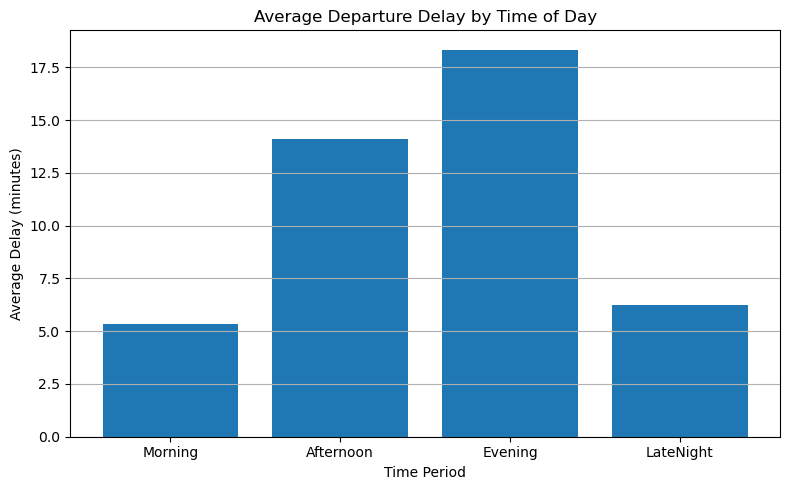

In [47]:
# Sorting of time periods
order = ['Morning', 'Afternoon', 'Evening', 'LateNight']
df_delay_period['timeperiod'] = pd.Categorical(df_delay_period['timeperiod'], categories=order, ordered=True)
df_delay_period = df_delay_period.sort_values('timeperiod')

# Visualization
plt.figure(figsize=(8, 5))
plt.bar(df_delay_period['timeperiod'], df_delay_period['avgdepdelay'])
plt.title("Average Departure Delay by Time of Day")
plt.xlabel("Time Period")
plt.ylabel("Average Delay (minutes)")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


### 2.1.2 Hourly Delay and Flight Count (Morning)

In [48]:
query_morning_hourly = """
SELECT 
  CAST(CRSDepTime / 100 AS INT) AS DepHour,
  AVG(DepDelay) AS AvgDepDelay,
  COUNT(*) AS FlightCount
FROM year_2007
WHERE 
  DepDelay IS NOT NULL 
  AND Cancelled = 0 
  AND CRSDepTime IS NOT NULL 
  AND CRSDepTime BETWEEN 500 AND 1159
GROUP BY CAST(CRSDepTime / 100 AS INT)
ORDER BY DepHour

"""

cursor.execute(query_morning_hourly)
columns = [desc[0] for desc in cursor.description]
rows = cursor.fetchall()
df_morning_hourly = pd.DataFrame(rows, columns=columns)
print(df_morning_hourly)

   dephour  avgdepdelay  flightcount
0        5     2.334065        45988
1        6     2.293282       512166
2        7     3.450721       502728
3        8     4.914334       501577
4        9     6.348304       477459
5       10     7.495337       459285
6       11     8.348521       485096


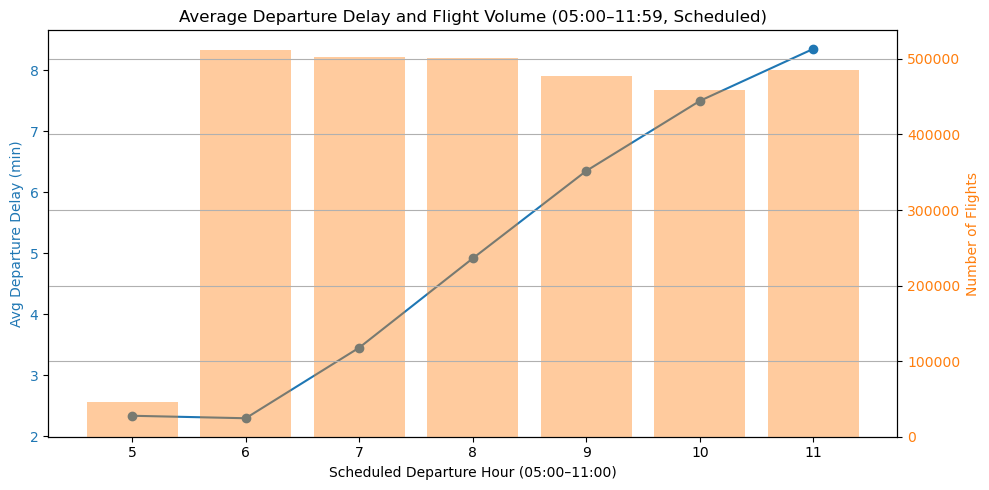

In [49]:
fig, ax1 = plt.subplots(figsize=(10, 5))

# Left Y-Axis: Average Delay (in minutes)  
color = 'tab:blue'
ax1.set_xlabel('Scheduled Departure Hour (05:00–11:00)')
ax1.set_ylabel('Avg Departure Delay (min)', color=color)
ax1.plot(df_morning_hourly['dephour'], df_morning_hourly['avgdepdelay'], color=color, marker='o', label='Avg Delay')
ax1.tick_params(axis='y', labelcolor=color)

# Right Y-Axis: Number of Flights  
ax2 = ax1.twinx()
color = 'tab:orange'
ax2.set_ylabel('Number of Flights', color=color)
ax2.bar(df_morning_hourly['dephour'], df_morning_hourly['flightcount'], color=color, alpha=0.4, label='Flight Count')
ax2.tick_params(axis='y', labelcolor=color)

# Visualization
plt.title('Average Departure Delay and Flight Volume (05:00–11:59, Scheduled)')
fig.tight_layout()
plt.grid(True)
plt.show()

<center><strong>Summary</strong></center>

  
Analysis shows that **morning flights** experience the **lowest average departure delay** of just **5.36 minutes**, while **evening flights** suffer the most, with an average delay of **18.34 minutes**.  
This pattern suggests that **delays tend to accumulate throughout the day**, likely due to earlier flight disruptions propagating into later schedules.

To further refine this finding, I examined the delay trend within the morning period. Based on the slope of the delay curve, I observed that delays between **07:00 and 08:59** increase at a **moderate and stable rate**, making this window the **optimal departure time**.   
  
This period offers a strong balance of **punctuality**, **high flight availability**, and **practical departure timing**, making it a highly **cost-effective choice** for travelers.

---

## 2.2 Delay Variation by Day of the Week 

"A flight is counted as '**on time**' if it operated **less than** 15 minutes later than the scheduled time shown in the carriers' Computerized Reservations Systems (CRS)."  
— [BTS: Airline On-Time Performance and Causes of Flight Delays](https://www.bts.gov/explore-topics-and-geography/topics/airline-time-performance-and-causes-flight-delays)

In [50]:
query_otp_weekday = """
SELECT 
  DayOfWeek,
  COUNT(*) AS TotalFlights,
  SUM(CASE WHEN ArrDelay <= 15 THEN 1 ELSE 0 END) AS OnTimeArrivals,
  ROUND(SUM(CASE WHEN ArrDelay <= 15 THEN 1 ELSE 0 END) / COUNT(*) * 100, 2) AS ArrivalOTP
FROM year_2007
WHERE Cancelled = 0 AND ArrDelay IS NOT NULL
GROUP BY DayOfWeek
ORDER BY DayOfWeek

"""

cursor.execute(query_otp_weekday)
columns = [desc[0] for desc in cursor.description]
rows = cursor.fetchall()
df_weekday_otp = pd.DataFrame(rows, columns=columns)
print(df_weekday_otp)

   dayofweek  totalflights  ontimearrivals  arrivalotp
0          1       1087794          822704       75.63
1          2       1050354          826681       78.70
2          3       1059851          813054       76.71
3          4       1069805          789203       73.77
4          5       1074710          780986       72.67
5          6        915626          737186       80.51
6          7       1017148          770845       75.78


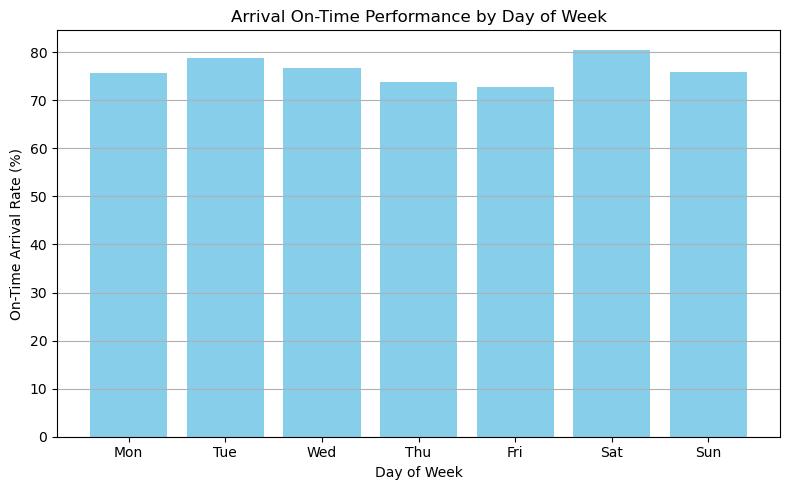

In [51]:
# Mapping weekday numbers to weekday names
weekday_map = {1: 'Mon', 2: 'Tue', 3: 'Wed', 4: 'Thu', 5: 'Fri', 6: 'Sat', 7: 'Sun'}
df_weekday_otp['DayName'] = df_weekday_otp['dayofweek'].map(weekday_map)
df_weekday_otp = df_weekday_otp.sort_values('dayofweek')

plt.figure(figsize=(8, 5))
plt.bar(df_weekday_otp['DayName'], df_weekday_otp['arrivalotp'], color='skyblue')
plt.title("Arrival On-Time Performance by Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("On-Time Arrival Rate (%)")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


<center><strong>Summary</strong></center>
  
**Saturday** shows the **highest on-time arrival rate (80.51%)**, making it the **most reliable day for air travel**.  
  
In contrast, **Thursday and Friday** exhibit the **lowest on-time performance**, likely due to **increased flight demand heading into the weekend**.  
  
*Travelers with time-sensitive schedules should prioritize flights on **Tuesday** or **Saturday**.*

---

## 2.3 Delay Variation by Month and Season  

### 2.3.1 Average Departure Delay by Month

In [52]:
query_otp_month = """
SELECT 
  Month,
  COUNT(*) AS TotalFlights,
  SUM(CASE WHEN ArrDelay <= 15 THEN 1 ELSE 0 END) AS OnTimeArrivals,
  ROUND(SUM(CASE WHEN ArrDelay <= 15 THEN 1 ELSE 0 END) / COUNT(*) * 100, 2) AS ArrivalOTP
FROM year_2007
WHERE Cancelled = 0 AND ArrDelay IS NOT NULL
GROUP BY Month
ORDER BY Month

"""

cursor.execute(query_otp_month)
columns = [desc[0] for desc in cursor.description]
rows = cursor.fetchall()
df_month_otp = pd.DataFrame(rows, columns=columns)
print(df_month_otp)

    month  totalflights  ontimearrivals  arrivalotp
0       1        604582          460285       76.13
1       2        538878          386126       71.65
2       3        621057          474199       76.35
3       4        602317          470846       78.17
4       5        623326          497603       79.83
5       6        609838          434541       71.26
6       7        632904          458847       72.50
7       8        638883          474107       74.21
8       9        592718          494886       83.49
9      10        621665          498331       80.16
10     11        597989          489179       81.80
11     12        591131          401709       67.96


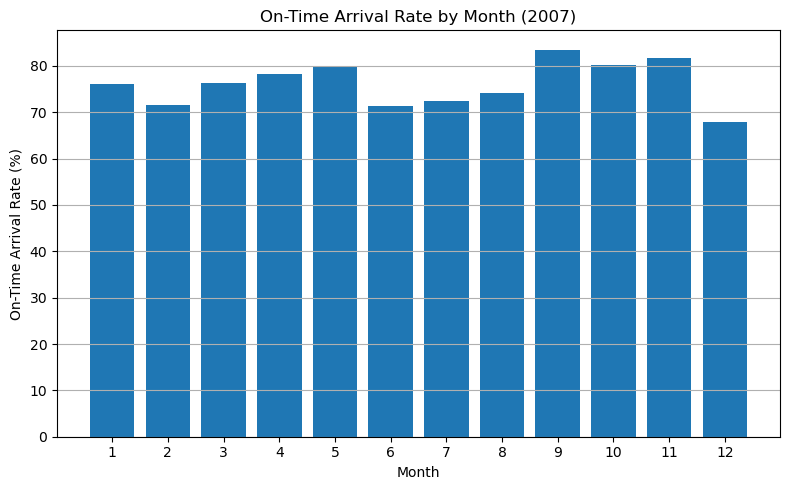

In [53]:
# Sorting by month
df_month_otp = df_month_otp.sort_values("month")

# Visualization
plt.figure(figsize=(8, 5))
plt.bar(df_month_otp['month'], df_month_otp['arrivalotp'])
plt.xticks(range(1, 13))
plt.title("On-Time Arrival Rate by Month (2007)")
plt.xlabel("Month")
plt.ylabel("On-Time Arrival Rate (%)")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


### 2.3.2 Average Departure Delay by Season

In [54]:
query_otp_season = """
SELECT 
  CASE 
    WHEN Month IN (12, 1, 2) THEN 'Winter'
    WHEN Month IN (3, 4, 5) THEN 'Spring'
    WHEN Month IN (6, 7, 8) THEN 'Summer'
    ELSE 'Fall'
  END AS Season,
  COUNT(*) AS TotalFlights,
  SUM(CASE WHEN ArrDelay <= 15 THEN 1 ELSE 0 END) AS OnTimeArrivals,
  ROUND(SUM(CASE WHEN ArrDelay <= 15 THEN 1 ELSE 0 END) / COUNT(*) * 100, 2) AS ArrivalOTP
FROM year_2007
WHERE Cancelled = 0 AND ArrDelay IS NOT NULL
GROUP BY 
  CASE 
    WHEN Month IN (12, 1, 2) THEN 'Winter'
    WHEN Month IN (3, 4, 5) THEN 'Spring'
    WHEN Month IN (6, 7, 8) THEN 'Summer'
    ELSE 'Fall'
  END
ORDER BY Season
"""

cursor.execute(query_otp_season)
columns = [desc[0] for desc in cursor.description]
rows = cursor.fetchall()
df_season_otp = pd.DataFrame(rows, columns=columns)
print(df_season_otp)

   season  totalflights  ontimearrivals  arrivalotp
0    Fall       1812372         1482396       81.79
1  Spring       1846700         1442648       78.12
2  Summer       1881625         1367495       72.68
3  Winter       1734591         1248120       71.95


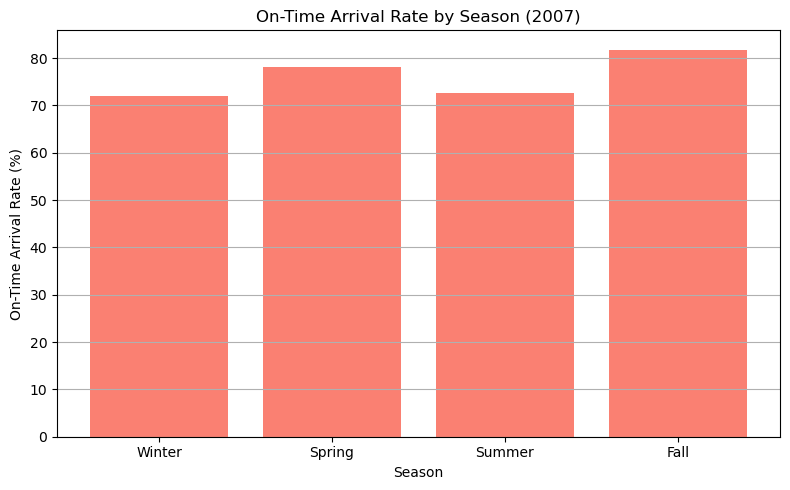

In [55]:
# Sorting
season_order = ['Winter', 'Spring', 'Summer', 'Fall']
df_season_otp['Season'] = pd.Categorical(df_season_otp['season'], categories=season_order, ordered=True)
df_season_otp = df_season_otp.sort_values('Season')

# Visualization
plt.figure(figsize=(8, 5))
plt.bar(df_season_otp['Season'], df_season_otp['arrivalotp'], color='salmon')
plt.title("On-Time Arrival Rate by Season (2007)")
plt.xlabel("Season")
plt.ylabel("On-Time Arrival Rate (%)")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


<center><strong>Summary</strong></center>
  
Fall (September to November) clearly stands out as the **most reliable travel season**, with on-time arrival rates consistently **above 81%**. Among these, **September (83.5%)** and **November (81.8%)** performed exceptionally well, offering travelers the **highest punctuality** of the year.

In contrast, **December** recorded the **worst on-time performance**, with only **67.96%** of flights arriving within 15 minutes of schedule—likely due to holiday congestion and winter storms. Similarly, **June and July** showed weaker performance, contributing to the lower punctuality in **summer (~72%)**.

  
**Recommendation:**  
- If schedule reliability is a priority, **plan your travel in fall**, especially in **September or November**.  
  
- Avoid flights in **December, June, or July** to reduce the risk of delay.

---

# 3. **Delay Factors**

*In this section, I analyze the primary causes of flight delays. I extracted five categories of delay data and calculated both the total delay minutes and their respective proportions, which allowed me to identify the most influential factors. Additionally, I used bar and pie charts to visually present the contribution of each delay type, providing a data-driven basis for the section's conclusions.*


## 3.1 Ranking of Delay Factors and Quantification of Influential Factors 

In [56]:
query_delay_factors = """
SELECT 
  SUM(CarrierDelay) AS CarrierDelay,
  SUM(WeatherDelay) AS WeatherDelay,
  SUM(NASDelay) AS NASDelay,
  SUM(SecurityDelay) AS SecurityDelay,
  SUM(LateAircraftDelay) AS LateAircraftDelay
FROM year_2007
WHERE DepDelay > 0 AND Cancelled = 0
"""
cursor.execute(query_delay_factors)
columns = [desc[0] for desc in cursor.description]
rows = cursor.fetchall()

df_factors = pd.DataFrame(rows, columns=columns).T.reset_index()
df_factors.columns = ['DelayFactor', 'TotalMinutes']
df_factors = df_factors.sort_values('TotalMinutes', ascending=False)
df_factors['Percentage'] = (df_factors['TotalMinutes'] / df_factors['TotalMinutes'].sum() * 100).round(2)
print(df_factors)


         DelayFactor  TotalMinutes  Percentage
4  lateaircraftdelay      37996081       40.10
0       carrierdelay      28461056       30.04
2           nasdelay      22377236       23.62
1       weatherdelay       5731856        6.05
3      securitydelay        176716        0.19


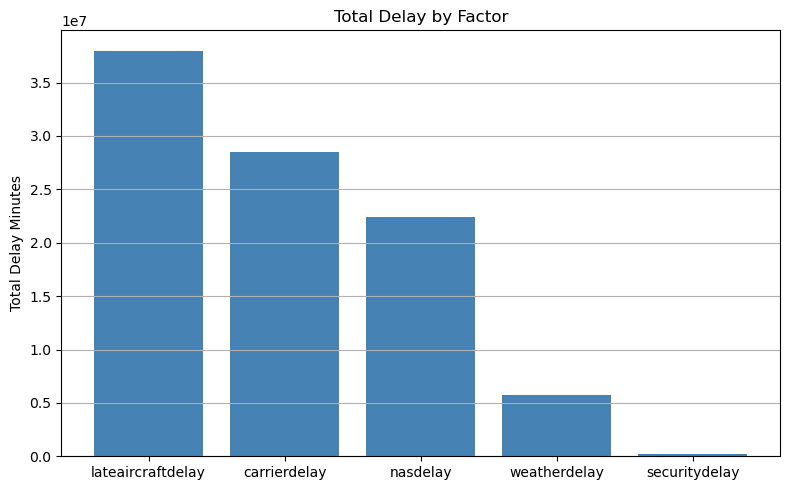

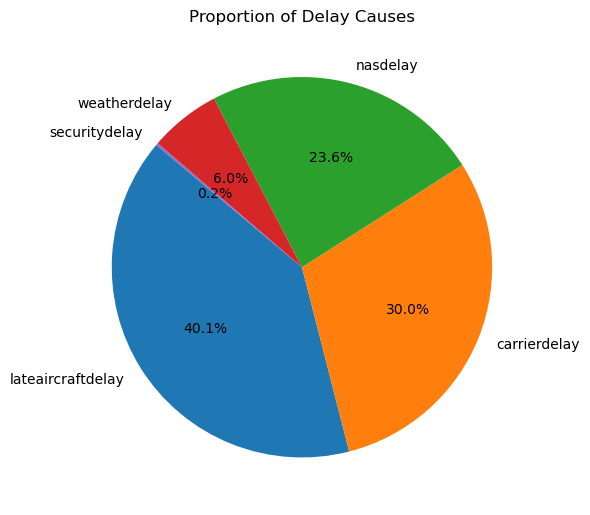

In [57]:
# Bar Chart: Total Minutes of Delay
plt.figure(figsize=(8, 5))
plt.bar(df_factors['DelayFactor'], df_factors['TotalMinutes'], color='steelblue')
plt.ylabel('Total Delay Minutes')
plt.title('Total Delay by Factor')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Pie Chart: Proportion of Each Factor
plt.figure(figsize=(6, 6))
plt.pie(df_factors['TotalMinutes'], labels=df_factors['DelayFactor'], autopct='%1.1f%%', startangle=140)
plt.title("Proportion of Delay Causes")
plt.tight_layout()
plt.show()


<center><strong>Summary</strong></center>
  
**Late Aircraft Delay** was the most significant contributor to flight delays in 2007, accounting for approximately **40.1%** of the total delay minutes. This suggests that many delays are propagated from earlier flights, indicating the importance of upstream schedule reliability.

**Carrier Delay**, which refers to delays caused by the airline itself (e.g., maintenance, crew issues, loading delays), was the second highest factor, contributing to **30.0%** of total delay time. **NAS Delay** (National Aviation System), which includes issues such as air traffic control and crowded airspace, was the third largest contributor at **23.6%**.

Meanwhile, **Weather Delay** accounted for **6.1%**, and **Security Delay** was minimal at **0.2%**, suggesting that weather disruptions, while significant, were not the dominant factor in overall delay minutes.

---

# 4. **Cancellation Analysis**

*In this section, I examine flight cancellations by analyzing their primary causes and exploring how cancellation rates vary across airlines, airports, months, and scheduled departure hours. I also include a monthly breakdown of cancellation reasons to highlight patterns across time and route segments.*


## 4.1 Analysis of Primary Cancellation Reasons

In [58]:
query_cancellation_reason = """
SELECT 
  CancellationCode,
  COUNT(*) AS CancelledCount
FROM year_2007
WHERE Cancelled = 1
GROUP BY CancellationCode
ORDER BY CancelledCount DESC
"""
cursor.execute(query_cancellation_reason)
columns = [desc[0] for desc in cursor.description]
rows = cursor.fetchall()
df_reason = pd.DataFrame(rows, columns=columns)
print(df_reason)

  cancellationcode  cancelledcount
0                A           66779
1                B           61935
2                C           31995
3                D              39


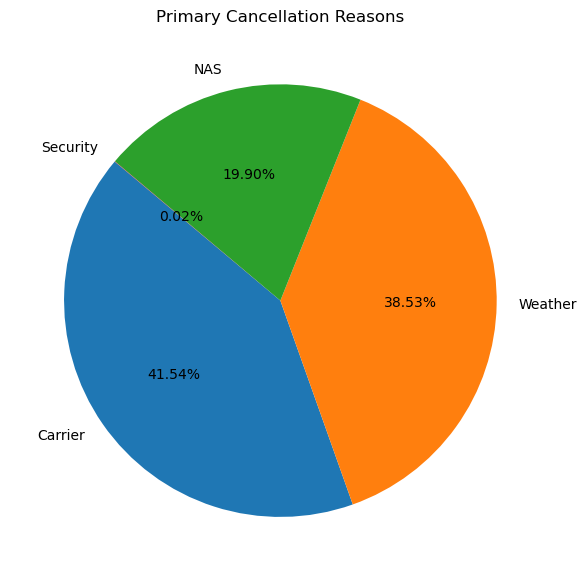

In [59]:
code_map = {
    'A': 'Carrier',
    'B': 'Weather',
    'C': 'NAS',
    'D': 'Security'
}
df_reason['Reason'] = df_reason['cancellationcode'].map(code_map)
plt.figure(figsize=(6, 6))
plt.pie(
    df_reason['cancelledcount'],
    labels=df_reason['Reason'],
    autopct='%.2f%%',
    startangle=140
)
plt.title("Primary Cancellation Reasons")
plt.tight_layout()
plt.show()

## 4.2 Correlation of Cancellations with Airlines, Airports, and Time Dimensions

### 4.2.1 Cancellation Rates by Airline

   uniquecarrier  totalflights  cancelledflights  cancelrate
0             MQ        540494             22792       0.042
1             YV        294362             11287       0.038
2             OH        233787              8851       0.038
3             EV        286234              8920       0.031
4             9E        258851              7939       0.031
5             AA        633857             17924       0.028
6             XE        434773             10800       0.025
7             UA        490002             11929       0.024
8             OO        597882             14186       0.024
9             NW        414526              7814       0.019
10            B6        191450              3710       0.019
11            US        485447              8942       0.018
12            AS        160185              2563       0.016
13            DL        475889              6521       0.014
14            FL        263159              2602       0.010
15            WN       1

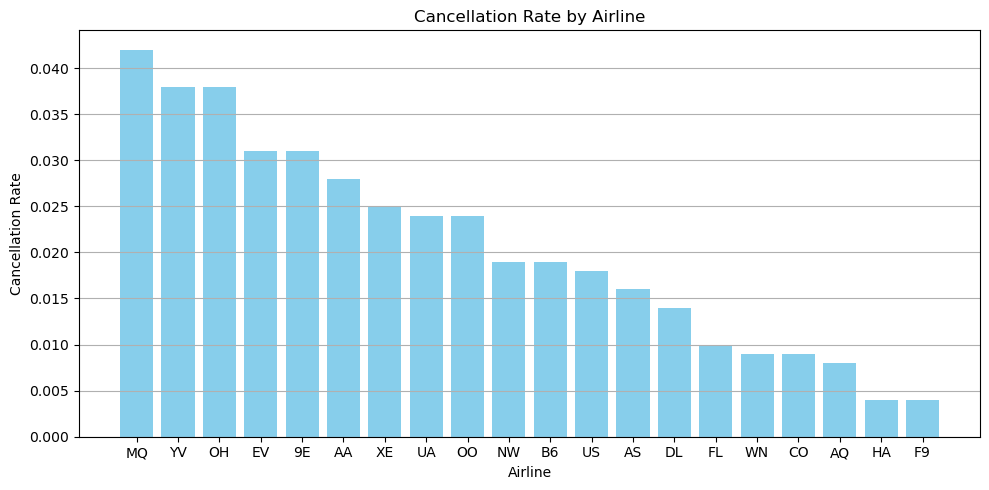

In [60]:
query_cancellation_by_carrier = """
SELECT 
  UniqueCarrier,
  COUNT(*) AS TotalFlights,
  SUM(Cancelled) AS CancelledFlights,
  ROUND(SUM(Cancelled) / COUNT(*), 3) AS CancelRate
FROM year_2007
GROUP BY UniqueCarrier
ORDER BY CancelRate DESC
"""
cursor.execute(query_cancellation_by_carrier)
columns = [desc[0] for desc in cursor.description]
rows = cursor.fetchall()
df_carrier = pd.DataFrame(rows, columns=columns)
print(df_carrier)

plt.figure(figsize=(10, 5))
plt.bar(df_carrier['uniquecarrier'], df_carrier['cancelrate'], color='skyblue')
plt.title("Cancellation Rate by Airline")
plt.xlabel("Airline")
plt.ylabel("Cancellation Rate")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

### 4.2.2 Cancellation Rates by Origin Airport

   origin  totalflights  cancelledflights  cancelrate
0     TEX           216                32       0.148
1     ACK           314                37       0.118
2     ALO           300                34       0.113
3     SUX           534                60       0.112
4     BJI           128                14       0.109
5     ASE          5305               556       0.105
6     INL           218                22       0.101
7     RHI           223                20       0.090
8     ADQ           691                57       0.082
9     SPI          1745               134       0.077
10    AZO          5121               375       0.073
11    SPS          2316               160       0.069
12    RST          4252               288       0.068
13    DBQ          1415                94       0.066
14    FLG          1911               121       0.063
15    PIA          5417               342       0.063
16    TUP           603                37       0.061
17    AKN           235     

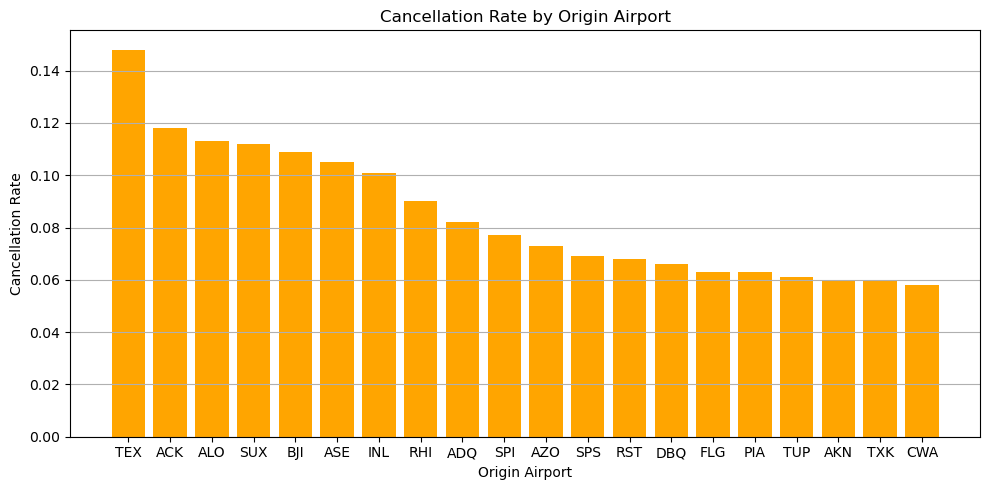

In [28]:
query_cancellation_by_origin = """
SELECT 
  Origin,
  COUNT(*) AS TotalFlights,
  SUM(Cancelled) AS CancelledFlights,
  ROUND(SUM(Cancelled) / COUNT(*), 3) AS CancelRate
FROM year_2007
GROUP BY Origin
HAVING COUNT(*) > 100
ORDER BY CancelRate DESC
LIMIT 20
"""
cursor.execute(query_cancellation_by_origin)
columns = [desc[0] for desc in cursor.description]
rows = cursor.fetchall()
df_origin = pd.DataFrame(rows, columns=columns)
print(df_origin)

plt.figure(figsize=(10, 5))
plt.bar(df_origin['origin'], df_origin['cancelrate'], color='orange')
plt.title("Cancellation Rate by Origin Airport")
plt.xlabel("Origin Airport")
plt.ylabel("Cancellation Rate")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


### 4.2.3 Monthly Cancellation Patterns and Reason Breakdown

    month  totalflights  cancelledflights  cancelrate
0       1        621559             15777        2.54
1       2        565604             25465        4.50
2       3        639209             16877        2.64
3       4        614648             11138        1.81
4       5        631609              6841        1.08
5       6        629280             17243        2.74
6       7        648560             13506        2.08
7       8        653279             12295        1.88
8       9        600187              6507        1.08
9      10        629992              7327        1.16
10     11        605149              6279        1.04
11     12        614139             21493        3.50


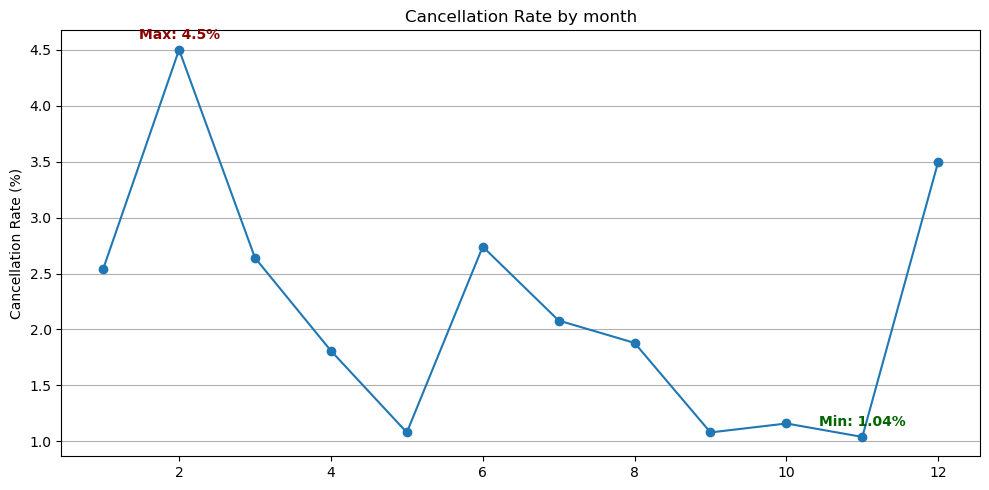

In [75]:
query_cancel_by_month = """
SELECT 
  Month,
  COUNT(*) AS TotalFlights,
  SUM(Cancelled) AS CancelledFlights,
  ROUND(SUM(Cancelled) / COUNT(*) * 100, 2) AS CancelRate
FROM year_2007
GROUP BY Month
ORDER BY Month
"""
cursor.execute(query_cancel_by_month)
columns = [desc[0] for desc in cursor.description]
df_cancel_month = pd.DataFrame(cursor.fetchall(), columns=columns)
print(df_cancel_month)

max_row = df_cancel_month.loc[df_cancel_month['cancelrate'].idxmax()]
min_row = df_cancel_month.loc[df_cancel_month['cancelrate'].idxmin()]
plt.figure(figsize=(10, 5))
plt.plot(df_cancel_month.iloc[:, 0], df_cancel_month['cancelrate'], marker='o')
plt.ylabel('Cancellation Rate (%)')
plt.title('Cancellation Rate by ' + df_cancel_month.columns[0])
plt.grid(axis='y')
plt.text(max_row['month'], max_row['cancelrate'] + 0.1,
         f"Max: {max_row['cancelrate']}%", ha='center', color='darkred', weight='bold')
plt.text(min_row['month'], min_row['cancelrate'] + 0.1,
         f"Min: {min_row['cancelrate']}%", ha='center', color='darkgreen', weight='bold')
plt.tight_layout()
plt.show()

    month cancellationcode  cancelledcount
0       1                A            5639
1       1                B            8253
2       1                C            1885
3       2                A            7641
4       2                B           15872
5       2                C            1950
6       2                D               2
7       3                A            5698
8       3                B            8245
9       3                C            2934
10      4                A            4579
11      4                B            3419
12      4                C            3111
13      4                D              29
14      5                A            3420
15      5                B            1690
16      5                C            1731
17      6                A            7744
18      6                B            4059
19      6                C            5438
20      6                D               2
21      7                A            6377
22      7  

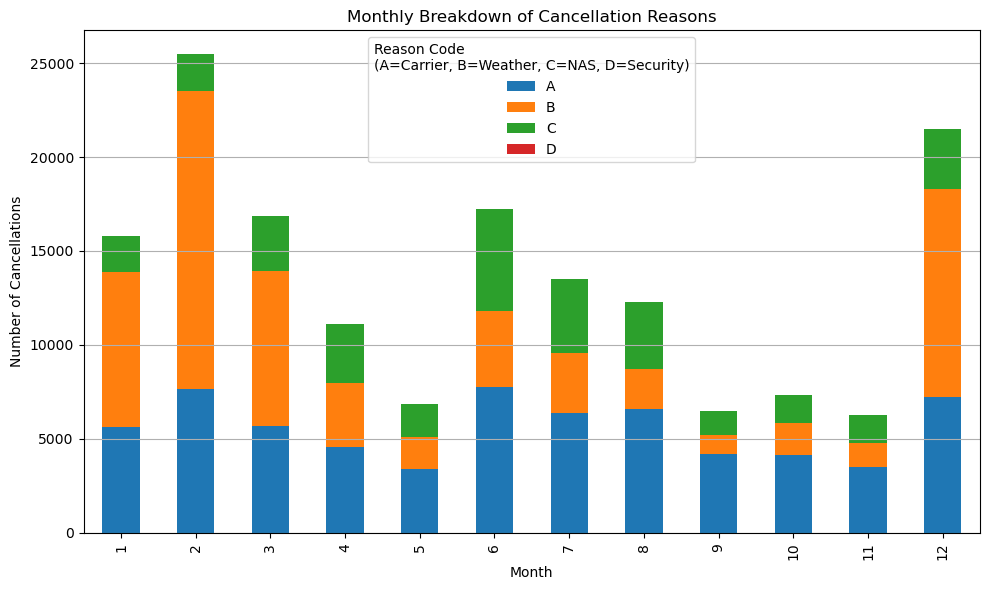

In [35]:
query_reason_by_month = """
SELECT 
  Month,
  CancellationCode,
  COUNT(*) AS CancelledCount
FROM year_2007
WHERE Cancelled = 1
GROUP BY Month, CancellationCode
ORDER BY Month, CancellationCode
"""
cursor.execute(query_reason_by_month)
columns = [desc[0] for desc in cursor.description]
rows = cursor.fetchall()
df_reason_month = pd.DataFrame(rows, columns=columns)
print(df_reason_month)

df_pivot = df_reason_month.pivot(index='month', columns='cancellationcode', values='cancelledcount').fillna(0)
df_pivot.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title("Monthly Breakdown of Cancellation Reasons")
plt.ylabel("Number of Cancellations")
plt.xlabel("Month")
plt.legend(title='Reason Code\n(A=Carrier, B=Weather, C=NAS, D=Security)')
plt.tight_layout()
plt.grid(axis='y')
plt.show()


### 4.2.4 Cancellations by Hour of Scheduled Departure

    hourblock  totalflights  cancelledflights  cancelrate
0           0          9868                64        0.65
1           1          3572                39        1.09
2           2           861                11        1.28
3           3           331                 6        1.81
4           4           815                13        1.60
5           5         47090              1102        2.34
6           6        523092             10926        2.09
7           7        511861              9133        1.78
8           8        510483              8906        1.74
9           9        486368              8909        1.83
10         10        467421              8136        1.74
11         11        493960              8864        1.79
12         12        461209              8651        1.88
13         13        485993              9662        1.99
14         14        459263              9710        2.11
15         15        451493             10984        2.43
16         16 

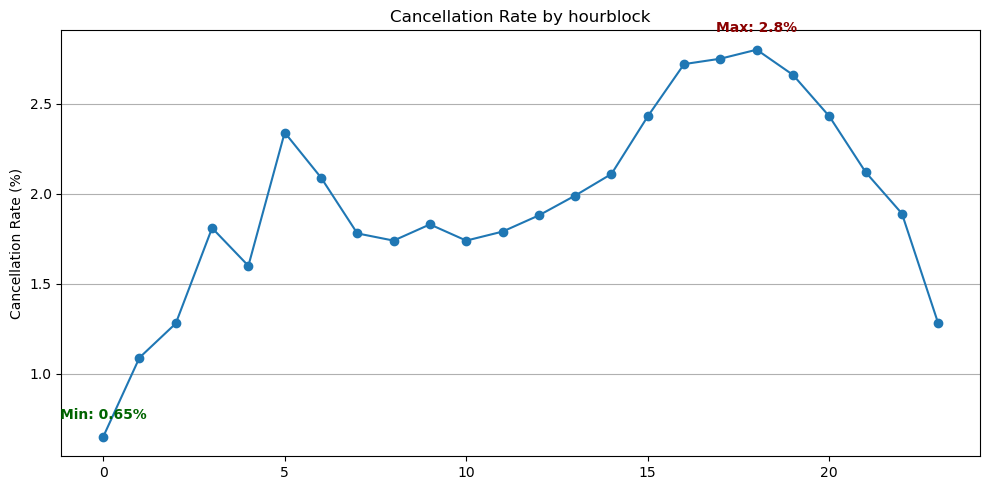

In [76]:
query_cancel_by_hour = """
SELECT 
  FLOOR(CRSDepTime / 100) AS HourBlock,
  COUNT(*) AS TotalFlights,
  SUM(Cancelled) AS CancelledFlights,
  ROUND(SUM(Cancelled) / COUNT(*) * 100, 2) AS CancelRate
FROM year_2007
WHERE CRSDepTime IS NOT NULL
GROUP BY FLOOR(CRSDepTime / 100)
ORDER BY HourBlock
"""

cursor.execute(query_cancel_by_hour)
columns = [desc[0] for desc in cursor.description]
rows = cursor.fetchall()
df_cancel_by_hour = pd.DataFrame(rows, columns=columns)
print(df_cancel_by_hour)

max_row = df_cancel_by_hour.loc[df_cancel_by_hour['cancelrate'].idxmax()]
min_row = df_cancel_by_hour.loc[df_cancel_by_hour['cancelrate'].idxmin()]

plt.figure(figsize=(10, 5))
plt.plot(df_cancel_by_hour.iloc[:, 0], df_cancel_by_hour['cancelrate'], marker='o')
plt.ylabel('Cancellation Rate (%)')
plt.title('Cancellation Rate by ' + df_cancel_by_hour.columns[0])
plt.grid(axis='y')
plt.text(max_row['hourblock'], max_row['cancelrate'] + 0.1,
         f"Max: {max_row['cancelrate']}%", ha='center', color='darkred', weight='bold')
plt.text(min_row['hourblock'], min_row['cancelrate'] + 0.1,
         f"Min: {min_row['cancelrate']}%", ha='center', color='darkgreen', weight='bold')
plt.tight_layout()
plt.show()


<center><strong>Summary</strong></center>

Comprehensive analysis shows that the **leading cause of flight cancellations is carrier-related issues**, followed by weather and National Aviation System (NAS) factors. In terms of cancellation rates, certain airlines (such as **MQ and YV**) exhibit significantly higher rates, well above the overall average. At the airport level, **smaller regional airports** (such as TEX and ACK) experience more frequent cancellations, indicating limited operational flexibility in handling disruptions.

From a temporal perspective, cancellations are more concentrated in the **winter months**, particularly in **February and December**. The stacked bar chart reveals that **weather-related cancellations account for a substantial proportion** during this period, indicating that adverse weather conditions have a significant impact on flight operations in colder seasons. Additionally, although the number of flights is relatively low during the Late Night period (0–5 AM), the **cancellation rate shows a steep upward trend**, suggesting a higher concentration of cancellations during this time window.



---



# 5. **Problematic Routes**

*In this section, I will identify the routes, airlines, and flight numbers that have consistently performed poorly in terms of flight cancellations and delays. First, I will rank the origin-destination pairs by cancellation rate, and then analyze the average arrival delay. Additionally, I will investigate the causes of cancellations and delays on these routes to better understand the factors contributing to these issues.*


## 5.1 Identification of Poorly Performing Routes and Flights


### 5.1.1 Average Departure Delays by Route

  origin dest  totalflights  avgdepdelay
0    LAX  EGE           113        63.52
1    ACK  JFK           132        55.09
2    EGE  MIA            33        51.42
3    EWR  LIT           323        49.77
4    ACK  EWR           145        47.94
5    ASE  ORD           225        47.59
6    LEX  EWR           312        46.66
7    BGR  EWR           404        45.66
8    EWR  TUL           329        44.73
9    MSN  EWR           309        43.09


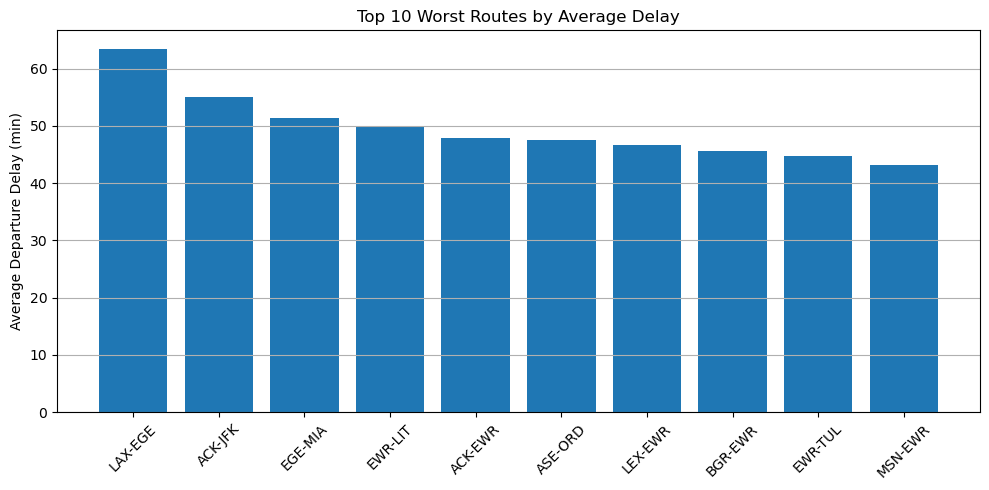

In [85]:
query_delay_routes = """
SELECT 
  Origin,
  Dest,
  COUNT(*) AS TotalFlights,
  ROUND(AVG(DepDelay), 2) AS AvgDepDelay
FROM year_2007
WHERE Cancelled = 0 AND DepDelay IS NOT NULL
GROUP BY Origin, Dest
HAVING COUNT(*) > 30
ORDER BY AvgDepDelay DESC
LIMIT 10

"""
cursor.execute(query_delay_routes)
columns = [desc[0] for desc in cursor.description]
rows = cursor.fetchall()
df_bad_routes = pd.DataFrame(rows, columns=columns)
print(df_bad_routes)

df_bad_routes['Route'] = df_bad_routes['origin'] + '-' + df_bad_routes['dest']
plt.figure(figsize=(10, 5))
plt.bar(df_bad_routes['Route'], df_bad_routes['avgdepdelay'])
plt.xticks(rotation=45)
plt.ylabel('Average Departure Delay (min)')
plt.title('Top 10 Worst Routes by Average Delay')
plt.tight_layout()
plt.grid(axis='y')
plt.show()

### 5.1.2 Average Departure Delays by Flight Number

  uniquecarrier  flightnum  totalflights  avgdepdelay
0            CO        540            35        73.63
1            OO       6910            33        69.36
2            OO       2874           143        69.20
3            B6        515           108        68.80
4            AA       1084            86        68.59
5            CO        552           301        67.49
6            OO       2875           136        66.39
7            OO       6924            33        64.76
8            CO       1187           305        63.85
9            CO       1162           228        63.55


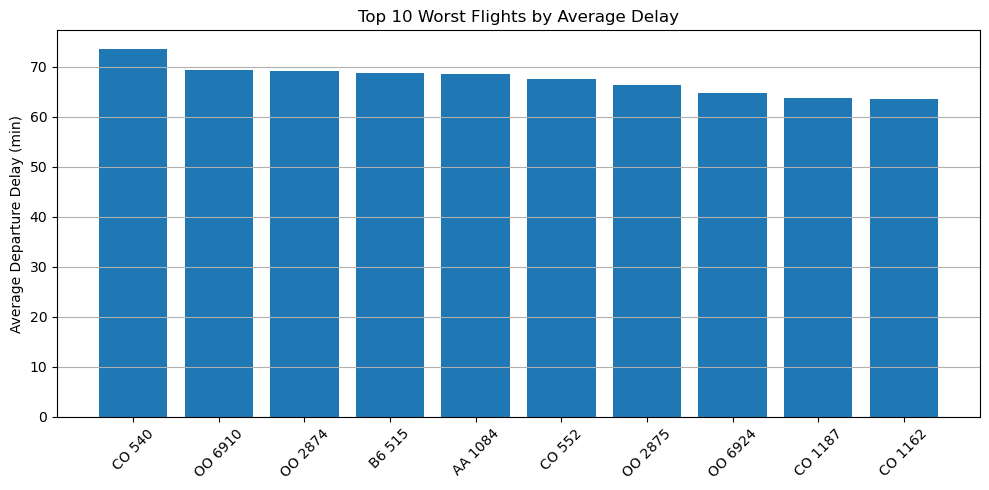

In [86]:
query_delay_flights = """
SELECT 
  UniqueCarrier,
  FlightNum,
  COUNT(*) AS TotalFlights,
  ROUND(AVG(DepDelay), 2) AS AvgDepDelay
FROM year_2007
WHERE Cancelled = 0 AND DepDelay IS NOT NULL
GROUP BY UniqueCarrier, FlightNum
HAVING COUNT(*) > 30
ORDER BY AvgDepDelay DESC
LIMIT 10
"""
cursor.execute(query_delay_flights)
columns = [desc[0] for desc in cursor.description]
rows = cursor.fetchall()
df_bad_flights = pd.DataFrame(rows, columns=columns)
print(df_bad_flights)

df_bad_flights['FlightID'] = df_bad_flights['uniquecarrier'] + ' ' + df_bad_flights['flightnum'].astype(str)
plt.figure(figsize=(10, 5))
plt.bar(df_bad_flights['FlightID'], df_bad_flights['avgdepdelay'])
plt.xticks(rotation=45)
plt.ylabel('Average Departure Delay (min)')
plt.title('Top 10 Worst Flights by Average Delay')
plt.tight_layout()
plt.grid(axis='y')
plt.show()


## 5.2 Analysis of Delay and Cancellation Causes

### 5.2.1 Breakdown of Delay Causes for Top Problematic Routes

  origin dest  totalflights  totaldelay  carrierdelay  weatherdelay  nasdelay  \
0    ORD  LGA          5452      248994         32265          9940    131056   
1    ORD  EWR          4131      237638         23226          6582    128779   
2    LGA  ORD          4898      228135         27397          7188     93875   
3    EWR  ORD          3629      196984         22567          5535     77999   
4    ATL  EWR          4021      184289         24014          4820    113794   
5    ORD  MSP          4472      183989         36211         11673     44875   
6    ATL  LGA          5569      180504         24530          2786    112775   
7    DFW  ORD          4241      179230         27946         12899     65525   
8    LAX  SFO          5060      173563         33616          1601     62523   
9    BOS  JFK          3467      173149         37791         17201     83411   

   securitydelay  lateaircraftdelay  
0              1              90441  
1             15              84

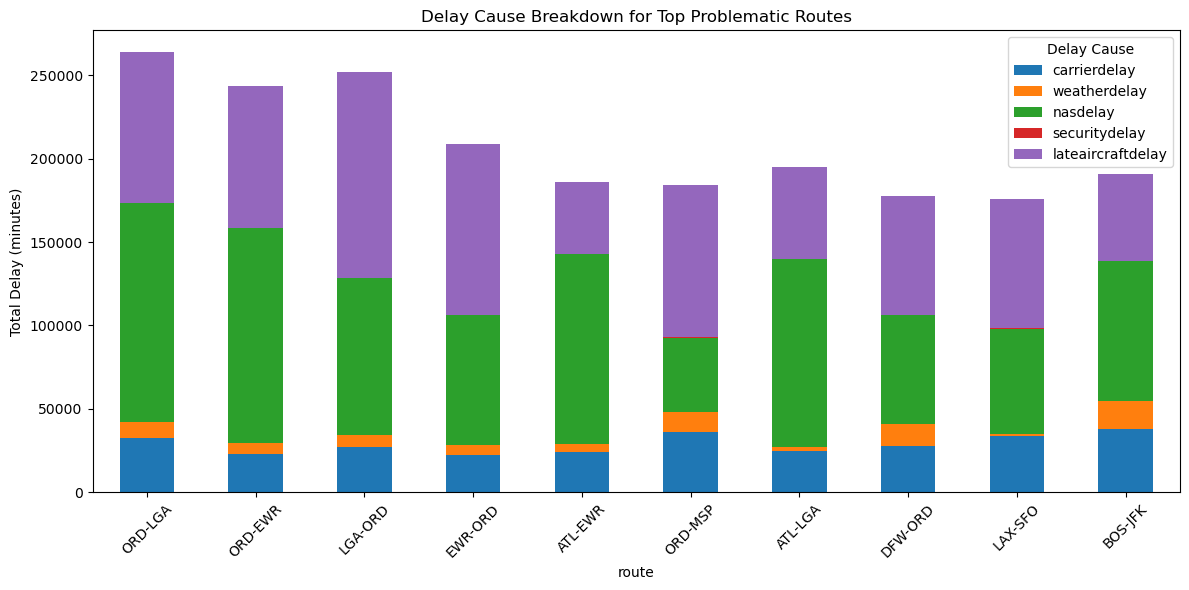

In [41]:
query_delay_breakdown = """
SELECT 
  Origin,
  Dest,
  COUNT(*) AS TotalFlights,
  SUM(DepDelay) AS TotalDelay,
  SUM(CarrierDelay) AS CarrierDelay,
  SUM(WeatherDelay) AS WeatherDelay,
  SUM(NASDelay) AS NASDelay,
  SUM(SecurityDelay) AS SecurityDelay,
  SUM(LateAircraftDelay) AS LateAircraftDelay
FROM year_2007
WHERE Cancelled = 0 AND DepDelay > 0
GROUP BY Origin, Dest
HAVING COUNT(*) > 30
ORDER BY TotalDelay DESC
LIMIT 10
"""
cursor.execute(query_delay_breakdown)
columns = [desc[0] for desc in cursor.description]
rows = cursor.fetchall()
df_delay_breakdown = pd.DataFrame(rows, columns=columns)
print(df_delay_breakdown)

df_delay_breakdown['route'] = df_delay_breakdown['origin'] + '-' + df_delay_breakdown['dest']
df_delay_breakdown = df_delay_breakdown.sort_values('totaldelay', ascending=False)


delay_types = ['carrierdelay', 'weatherdelay', 'nasdelay', 'securitydelay', 'lateaircraftdelay']
df_plot = df_delay_breakdown.set_index('route')[delay_types]
df_plot.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.ylabel("Total Delay (minutes)")
plt.title("Delay Cause Breakdown for Top Problematic Routes")
plt.xticks(rotation=45)
plt.legend(title='Delay Cause')
plt.tight_layout()
plt.show()

### 5.2.2 Breakdown of Cancellation Reasons for Top Cancelled Routes

   r.origin r.dest f.cancellationcode  cancelledcount
0       LGA    LEX                  B              31
1       TEX    PHX                  B              18
2       ASE    PHX                  B              18
3       JFK    IND                  B              17
4       ACK    EWR                  C              14
5       EWR    ACK                  C              13
6       PHX    ASE                  B              12
7       SFO    ASE                  B              12
8       ASE    SFO                  B              11
9       LGA    FNT                  A              11
10      TEX    PHX                  A              11
11      EWR    ACK                  B               9
12      ACK    EWR                  B               8
13      ASE    PHX                  A               8
14      PHX    ASE                  A               8
15      LGA    LEX                  A               7
16      LGA    LEX                  C               5
17      TEX    PHX          

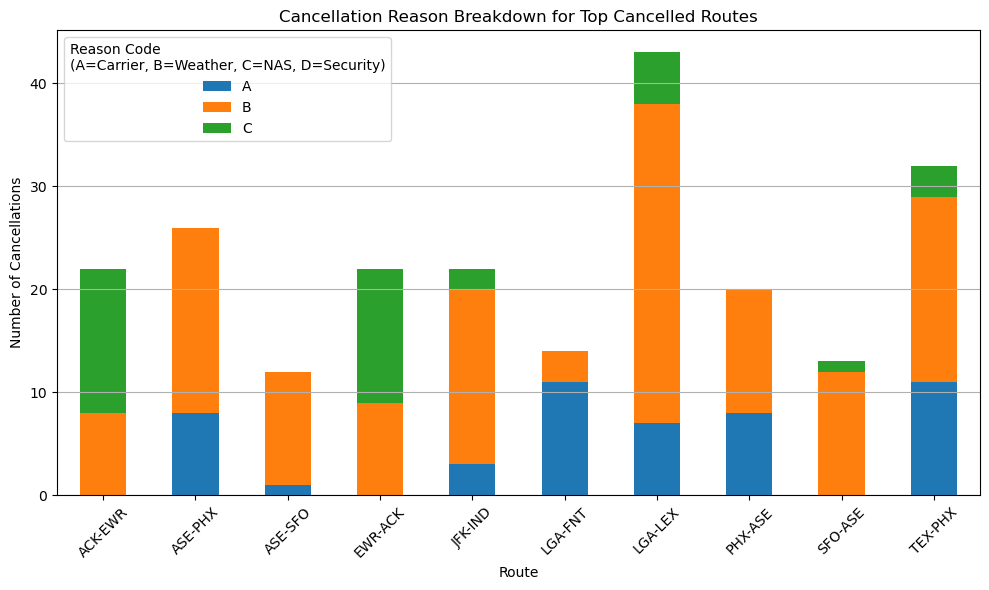

In [103]:
query_cancel_reason_breakdown = """
WITH top_cancelled_routes AS (
  SELECT 
    Origin, 
    Dest,
    COUNT(*) AS TotalFlights,
    SUM(Cancelled) AS CancelledFlights,
    ROUND(SUM(Cancelled) / COUNT(*), 3) AS CancelRate
  FROM year_2007
  GROUP BY Origin, Dest
  HAVING TotalFlights > 30
  ORDER BY CancelRate DESC
  LIMIT 10
)

SELECT 
  r.Origin,
  r.Dest,
  f.CancellationCode,
  COUNT(*) AS CancelledCount
FROM year_2007 f
JOIN top_cancelled_routes r
  ON f.Origin = r.Origin AND f.Dest = r.Dest
WHERE f.Cancelled = 1
GROUP BY r.Origin, r.Dest, f.CancellationCode
ORDER BY CancelledCount DESC
"""

cursor.execute(query_cancel_reason_breakdown)
columns = [desc[0] for desc in cursor.description]
rows = cursor.fetchall()
df_cancel_reasons = pd.DataFrame(rows, columns=columns)
print(df_cancel_reasons)


df_cancel_reasons['Route'] = df_cancel_reasons['r.origin'] + '-' + df_cancel_reasons['r.dest']
df_pivot = df_cancel_reasons.pivot(index='Route', columns='f.cancellationcode', values='cancelledcount').fillna(0)
df_pivot.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Cancellation Reason Breakdown for Top Cancelled Routes')
plt.ylabel('Number of Cancellations')
plt.xlabel('Route')
plt.xticks(rotation=45)
plt.legend(title='Reason Code\n(A=Carrier, B=Weather, C=NAS, D=Security)')
plt.tight_layout()
plt.grid(axis='y')
plt.show()

<center><strong>Summary</strong></center>

A comprehensive analysis of delay and cancellation data reveals several **underperforming routes and flights**. In terms of average departure delay, routes such as **LAX–EGE** and **ACK–JFK**, along with several flights operated by **CO and OO airlines**, show significantly high average delays—**exceeding 60 minutes per flight**. For total delay minutes, heavily trafficked routes like **ORD–LGA** and **ORD–EWR** top the list, with delays largely driven by **NAS-related congestion** and **late aircraft connections**.  

Regarding cancellations, the top ten most affected routes are primarily impacted by **weather (Code B)** and **carrier-related (Code A)** causes. Routes such as **LGA–LEX** and **TEX–PHX** are dominated by weather-driven cancellations. Overall, **systemic traffic control constraints**, **regional weather exposure**, and **operational limitations** jointly contribute to the poor reliability observed on these problematic routes.


---

# 6. **Conclusion**

*This project presents a comprehensive analysis of U.S. domestic flight operations in 2007, focusing on both delay and cancellation behavior. The workflow combines Hive SQL for large-scale data querying and Python-based processing and visualization to explore temporal delay trends, identify leading causes of disruption, and pinpoint underperforming routes.*

*The analysis begins by examining patterns across different times of day, days of the week, and months. Morning flights showed superior punctuality, while delays intensified into the evening and cancellations peaked in winter and late-night hours. Delay decomposition reveals that late aircraft and carrier-related factors are the dominant sources of delay minutes, while cancellations are mainly driven by weather and airline operations. Detailed cancellation breakdowns across airlines, airports, and time periods further exposed operational bottlenecks in regional systems.*

*The final section identifies problematic routes and flight numbers with the worst performance, and dissects the structure of their delays and cancellations. Routes such as ORD–LGA, ACK–JFK, and those operated by OO and CO airlines consistently exhibited extended delays and scheduling vulnerability.*

*By linking temporal, operational, and route-level perspectives, this analysis delivers a data-grounded understanding of systemic inefficiencies in airline performance. These insights can support more robust scheduling decisions, inform delay mitigation policies, and improve reliability planning for high-risk segments of the air travel network.*
